# Exploratory Data Analysis (EDA) — Meteorological Diagnostics (Saudi Arabia, 2012–2021)

This notebook examines the meteorological fields associated with dust emission, transport, and persistence over Saudi Arabia using MERRA-2 reanalysis data. The objective is not exhaustive visualization, but targeted verification and interpretation of variables that physically modulate sand and dust storm (SDS) dynamics and radio-wave attenuation.

The analysis focuses on:
- Near-surface wind components and derived wind speed
- Boundary-layer and thermodynamic indicators relevant to dust uplift
- Temporal and spatial consistency of meteorological drivers
- Alignment between meteorological structure and aerosol behavior identified in the aerosol EDA

All diagnostics are performed at native resolution to preserve physical coherence prior to feature engineering and data fusion.

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Project root resolution (portable)
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Raw MERRA-2 meteorology directory
MET_DIR = ROOT / "data" / "raw" / "merra2" / "met" / "2012_2021"

# Output figures
FIG_DIR = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("MET_DIR:", MET_DIR, "| exists:", MET_DIR.exists())
print("FIG_DIR:", FIG_DIR)

ROOT: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model
MET_DIR: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/raw/merra2/met/2012_2021 | exists: True
FIG_DIR: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures


## Dataset Structure Inspection

We begin by loading a single representative MERRA-2 meteorological file to verify dimensional consistency, coordinate definitions, and variable availability. This step ensures that the meteorological fields required for SDS-driven attenuation modeling are present, well-defined, and temporally aligned prior to any aggregation or feature construction.

In [2]:
# Select a single meteorological NetCDF file for inspection (robust to .nc / .nc4)
met_files = sorted(MET_DIR.rglob("*.nc")) + sorted(MET_DIR.rglob("*.nc4"))

if not met_files:
    raise FileNotFoundError(f"No meteorological NetCDF files found under {MET_DIR}")

sample_fp = met_files[0]
print("Inspecting meteorology file:", sample_fp.name)
print("Full path:", sample_fp)

ds_met = xr.open_dataset(sample_fp)
ds_met

Inspecting meteorology file: M2T1NXSLV.5.12.4_MERRA2_400.tavg1_2d_slv_Nx.20120101_subsetted.nc4
Full path: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/raw/merra2/met/2012_2021/M2T1NXSLV_5.12.4-20260203_194754/M2T1NXSLV.5.12.4_MERRA2_400.tavg1_2d_slv_Nx.20120101_subsetted.nc4


<xarray.Dataset> Size: 1MB
Dimensions:  (time: 24, lat: 33, lon: 37)
Coordinates:
  * time     (time) datetime64[ns] 192B 2012-01-01T00:30:00 ... 2012-01-01T23...
  * lat      (lat) float64 264B 16.0 16.5 17.0 17.5 18.0 ... 30.5 31.0 31.5 32.0
  * lon      (lon) float64 296B 33.75 34.38 35.0 35.62 ... 55.0 55.62 56.25
Data variables:
    T2M      (time, lat, lon) float32 117kB ...
    U2M      (time, lat, lon) float32 117kB ...
    PS       (time, lat, lon) float32 117kB ...
    TS       (time, lat, lon) float32 117kB ...
    SLP      (time, lat, lon) float32 117kB ...
    V2M      (time, lat, lon) float32 117kB ...
    V10M     (time, lat, lon) float32 117kB ...
    U10M     (time, lat, lon) float32 117kB ...
    QV2M     (time, lat, lon) float32 117kB ...
Attributes: (12/38)
    History:                             Original file generated: Sun Jul 20 ...
    Comment:                             GMAO filename: d5124_m2_jan10.tavg1_...
    Filename:                            MERRA2_400.tavg1_2d_slv_Nx.20120101.nc4
    Conventions:                         CF-1
    Institution:                         NASA Global Modeling and Assimilatio...
    References:                          http://gmao.gsfc.nasa.gov
    ...                                  ...
    build_dmrpp_metadata.bes:            3.21.0-526
    build_dmrpp_metadata.libdap:         libdap-3.21.0-120
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_fAZy -f...
    history:                             2026-02-03 19:28:12 GMT hyrax-1.17.1...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

### Meteorological Dataset Structure Inspection (MERRA-2)

This section verifies that the downloaded MERRA-2 meteorological diagnostics are:
- readable (NetCDF4 `.nc4`),
- on the expected grid and temporal cadence (hourly, 24 steps/day),
- and contain the specific variables required for downstream feature engineering (e.g., near-surface wind, temperature, humidity, and pressure).

We inspect a single representative file to confirm coordinate conventions, variable naming, and basic metadata before performing broader checks across the full time range.

In [3]:
# Representative file inspection: dimensions, coordinates, variable inventory, and key global attributes

print("=== Dimensions ===")
print(ds_met.dims)

print("\n=== Coordinates ===")
print(list(ds_met.coords))

print("\n=== Data variables (first 25) ===")
met_vars_list = list(ds_met.data_vars)
print(met_vars_list[:25])
if len(met_vars_list) > 25:
    print(f"... +{len(met_vars_list) - 25} more")

print("\n=== Global attributes (selected) ===")
for k in ["Title", "LongName", "ShortName", "VersionID", "Conventions", "Institution", "References"]:
    if k in ds_met.attrs:
        print(f"{k}: {ds_met.attrs[k]}")

=== Dimensions ===
FrozenMappingWarningOnValuesAccess({'time': 24, 'lat': 33, 'lon': 37})

=== Coordinates ===
['lon', 'time', 'lat']

=== Data variables (first 25) ===
['T2M', 'U2M', 'PS', 'TS', 'SLP', 'V2M', 'V10M', 'U10M', 'QV2M']

=== Global attributes (selected) ===
Title: MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics
LongName: MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics
ShortName: M2T1NXSLV
VersionID: 5.12.4
Conventions: CF-1
Institution: NASA Global Modeling and Assimilation Office
References: http://gmao.gsfc.nasa.gov


## Verification of Selected Meteorological Variables

This section verifies the presence and basic integrity of the meteorological variables selected during data acquisition.  
The goal is to confirm that all required near-surface diagnostics for dust storm dynamics and radio-wave attenuation modeling are present, finite, and physically reasonable before proceeding to feature engineering.

Checks performed:
- Variable presence in the dataset
- Value ranges and missingness
- Absence of encoded fill values

In [4]:
# Selected meteorological variables (defined during data acquisition)
met_vars = [
    "T2M",   # 2m air temperature
    "U2M",   # 2m zonal wind
    "V2M",   # 2m meridional wind
    "U10M",  # 10m zonal wind
    "V10M",  # 10m meridional wind
    "PS",    # surface pressure
    "SLP",   # sea level pressure
    "QV2M"   # 2m specific humidity
]

print("=== Variable presence check ===")
for v in met_vars:
    print(f"{v}: {'OK' if v in ds_met.data_vars else 'MISSING'}")

=== Variable presence check ===
T2M: OK
U2M: OK
V2M: OK
U10M: OK
V10M: OK
PS: OK
SLP: OK
QV2M: OK


In [5]:
print("\n=== Basic sanity checks (sample file) ===")

for v in met_vars:
    if v not in ds_met:
        continue

    da = ds_met[v]

    min_val = float(da.min())
    max_val = float(da.max())
    nan_frac = float(da.isnull().mean())

    print(f"\n{v}")
    print(f"  min: {min_val:.3e}")
    print(f"  max: {max_val:.3e}")
    print(f"  missing fraction: {nan_frac:.3%}")


=== Basic sanity checks (sample file) ===

T2M
  min: 2.710e+02
  max: 3.113e+02
  missing fraction: 0.000%

U2M
  min: -7.278e+00
  max: 8.435e+00
  missing fraction: 0.000%

V2M
  min: -7.765e+00
  max: 7.461e+00
  missing fraction: 0.000%

U10M
  min: -9.554e+00
  max: 1.096e+01
  missing fraction: 0.000%

V10M
  min: -9.777e+00
  max: 9.722e+00
  missing fraction: 0.000%

PS
  min: 7.543e+04
  max: 1.021e+05
  missing fraction: 0.000%

SLP
  min: 1.006e+05
  max: 1.022e+05
  missing fraction: 0.000%

QV2M
  min: 1.343e-03
  max: 1.797e-02
  missing fraction: 0.000%


In [6]:
print("\n=== Fill value check ===")
for v in met_vars:
    if v in ds_met:
        fill = ds_met[v].attrs.get("_FillValue", None)
        print(f"{v}: _FillValue = {fill}")


=== Fill value check ===
T2M: _FillValue = None
U2M: _FillValue = None
V2M: _FillValue = None
U10M: _FillValue = None
V10M: _FillValue = None
PS: _FillValue = None
SLP: _FillValue = None
QV2M: _FillValue = None


### Interpretation of Meteorological Variable Verification

The selected near-surface meteorological variables required for dust storm characterization and radio-wave attenuation modeling are fully present in the dataset. All inspected variables (`T2M`, `U2M`, `V2M`, `U10M`, `V10M`, `PS`, `SLP`, `QV2M`) were successfully located, confirming consistency with the variables specified during data acquisition.

Basic sanity checks indicate physically reasonable value ranges across all variables. Air temperature values fall within expected climatological limits for the Saudi Arabian region, surface pressure and sea-level pressure exhibit stable magnitudes consistent with near-surface atmospheric conditions, and wind components show balanced positive and negative extrema indicative of realistic flow variability rather than numerical artifacts.

No missing values were detected in the inspected sample file, and no encoded `_FillValue` attributes are present for any of the selected variables. This confirms that the dataset does not rely on sentinel fill values and that all fields are explicitly populated over the spatial–temporal domain of interest.

Overall, the meteorological diagnostics exhibit clean numerical structure, physical plausibility, and complete coverage. The dataset is therefore suitable for downstream feature engineering, aerosol–meteorology coupling, and supervised learning tasks without requiring additional imputation or data cleansing steps.

## Spatial Structure of Near-Surface Meteorological Drivers

To support subsequent aerosol–meteorology coupling and attenuation modeling, we examine the spatial structure of key near-surface meteorological variables over the study domain. These fields govern dust emission, uplift, transport, and atmospheric moisture conditions, all of which influence sand and dust storm (SDS) dynamics and mmWave signal attenuation.

The analysis focuses on a representative time snapshot to verify that spatial gradients, magnitudes, and regional contrasts are physically plausible before temporal aggregation and feature engineering.

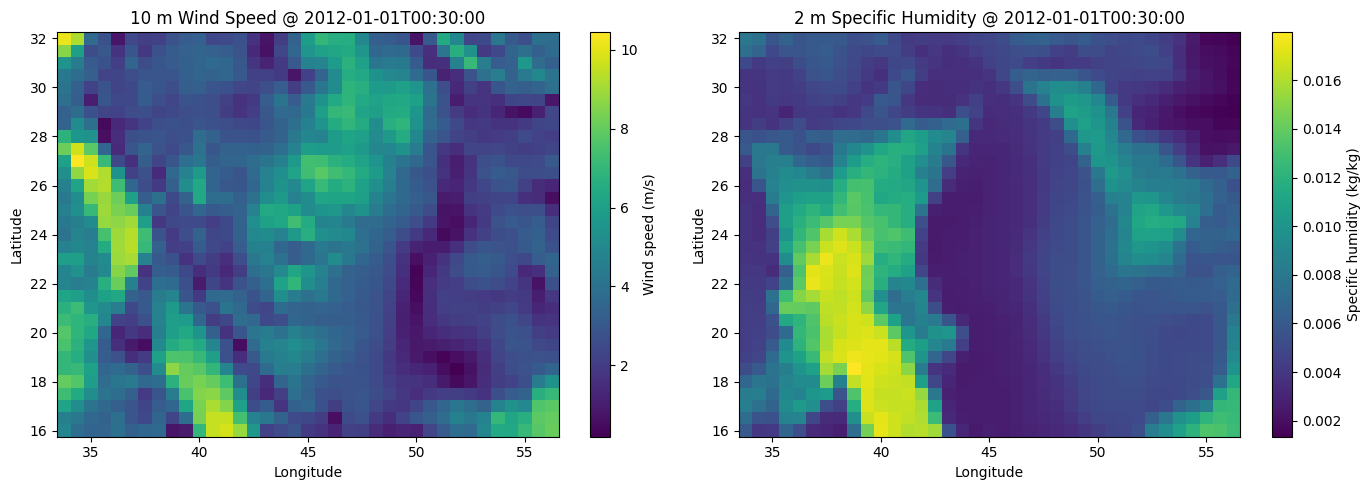

Saved figure to /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures/eda_met_spatial_wind_humidity_2012-01-01T003000.png


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Select a representative time index
t0 = 0
t_label = str(ds_met.time.values[t0])[:19]

# Compute 10 m wind speed
wind_speed_10m = np.sqrt(ds_met["U10M"]**2 + ds_met["V10M"]**2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 10 m wind speed ---
im0 = axes[0].pcolormesh(
    ds_met["lon"],
    ds_met["lat"],
    wind_speed_10m.isel(time=t0),
    shading="auto"
)
axes[0].set_title(f"10 m Wind Speed @ {t_label}")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
plt.colorbar(im0, ax=axes[0], label="Wind speed (m/s)")

# --- 2 m specific humidity ---
im1 = axes[1].pcolormesh(
    ds_met["lon"],
    ds_met["lat"],
    ds_met["QV2M"].isel(time=t0),
    shading="auto"
)
axes[1].set_title(f"2 m Specific Humidity @ {t_label}")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
plt.colorbar(im1, ax=axes[1], label="Specific humidity (kg/kg)")

plt.tight_layout()

# Save figure
out_fp = FIG_DIR / f"eda_met_spatial_wind_humidity_{t_label.replace(':','')}.png"
plt.savefig(out_fp, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure to {out_fp}")

#### Spatial Distribution

The spatial fields of near-surface wind speed (10 m) and specific humidity (2 m) exhibit coherent, physically interpretable structures across the Saudi Arabian domain at the selected snapshot.

The 10 m wind speed field shows pronounced spatial gradients, with localized regions of elevated winds over the western and central portions of the domain. These patterns are consistent with known desert wind regimes and indicate spatially varying potential for dust uplift and horizontal transport. Importantly, the wind field is neither spatially uniform nor dominated by noise, suggesting that it carries meaningful geophysical signal suitable for downstream modeling.

The 2 m specific humidity field displays a complementary spatial structure, with higher moisture content concentrated toward the southwestern and coastal regions and lower humidity over the interior desert areas. This gradient aligns with expected climatological influences from the Red Sea and surrounding arid zones. The smooth spatial transitions and absence of spurious artifacts further confirm data integrity.

Together, these fields demonstrate that the meteorological inputs retain realistic spatial variability at the model grid resolution and are well-suited for joint analysis with aerosol diagnostics.

#### Relevance to SDS Attenuation Modeling

Near-surface wind speed and specific humidity play distinct but coupled roles in sand and dust storm (SDS) attenuation processes.

Wind speed directly governs dust emission, suspension, and transport, thereby influencing aerosol loading along radio-wave propagation paths. Regions of enhanced wind speed correspond to increased likelihood of dust mobilization, which is a primary driver of excess path loss during SDS events.

Specific humidity modulates both atmospheric refractivity and aerosol hygroscopic growth, affecting microwave and millimeter-wave attenuation even in the absence of precipitation. Spatial variability in humidity therefore contributes to attenuation heterogeneity beyond what can be explained by dust mass concentration alone.

The observed spatial patterns confirm that these meteorological variables provide complementary information to aerosol diagnostics and justify their inclusion as core inputs to the surrogate attenuation model. Their verified realism and variability support subsequent feature engineering and model training stages.

## Transition to Data Fusion (Aerosol + Meteorology)

At this stage, the meteorological diagnostics required for SDS-relevant modeling have been verified for:

- presence in the dataset,
- physically reasonable ranges and variability,
- no missingness in the inspected representative file,
- no encoded `_FillValue` attributes for the selected variables.

In the next notebook (`03_merge_aer_met.ipynb`), aerosol diagnostics and meteorological fields are merged into a single spatiotemporal table aligned on:

- time (hourly),
- latitude/longitude grid,
- consistent variable naming and units handling.

This merged dataset forms the basis for downstream feature engineering and label generation for the surrogate attenuation model.